In [ ]:
from keras.models import Sequential
from keras.models import Input
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

from keras.metrics import TruePositives
from keras.metrics import FalsePositives
from keras.metrics import TrueNegatives
from keras.metrics import FalseNegatives 
from keras.metrics import BinaryAccuracy
from keras.metrics import Precision
from keras.metrics import Recall
from keras.metrics import AUC

from keras.optimizers import Adam

import kerastuner as kt

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import explained_variance_score

import pandas as pd
import numpy as np

import os

import time 

import math
import random

from datetime import datetime, date


import re

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from google.colab import drive



In [ ]:
!nvidia-smi

Mon Apr  5 17:17:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
gdrive_dir = '/content/gdrive/'

drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


# Read in voter file

In [ ]:
data_dir = os.path.join(gdrive_dir, "My Drive", "Homeless Coalition", 'trust fund campaign')

filename = 'voter file features collected.csv'

voter_file = pd.read_csv(os.path.join(data_dir, filename))

In [ ]:
voter_file.head(4)

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,PARTY_AFFILIATION,RESIDENTIAL_ADDRESS1_voter,RESIDENTIAL_SECONDARY_ADDR,RESIDENTIAL_CITY_voter,RESIDENTIAL_STATE_voter,RESIDENTIAL_ZIP_voter,RESIDENTIAL_ZIP_PLUS4,RESIDENTIAL_COUNTRY,RESIDENTIAL_POSTALCODE,tigerlineid,side,tract,block,lat,lon,MAILING_ADDRESS1,MAILING_SECONDARY_ADDRESS,MAILING_CITY,MAILING_STATE,MAILING_ZIP,MAILING_ZIP_PLUS4,MAILING_COUNTRY,MAILING_POSTAL_CODE,CAREER_CENTER,CITY,CITY_SCHOOL_DISTRICT,COUNTY_COURT_DISTRICT,CONGRESSIONAL_DISTRICT,COURT_OF_APPEALS,EDU_SERVICE_CENTER_DISTRICT,EXEMPTED_VILL_SCHOOL_DISTRICT,LIBRARY,LOCAL_SCHOOL_DISTRICT,MUNICIPAL_COURT_DISTRICT,PRECINCT_NAME,PRECINCT_CODE,STATE_BOARD_OF_EDUCATION,STATE_REPRESENTATIVE_DISTRICT,STATE_SENATE_DISTRICT,TOWNSHIP,VILLAGE,WARD,PRIMARY-03/07/2000,GENERAL-11/07/2000,SPECIAL-05/08/2001,GENERAL-11/06/2001,PRIMARY-05/07/2002,GENERAL-11/05/2002,SPECIAL-05/06/2003,GENERAL-11/04/2003,PRIMARY-03/02/2004,GENERAL-11/02/2004,SPECIAL-02/08/2005,PRIMARY-05/03/2005,PRIMARY-09/13/2005,GENERAL-11/08/2005,SPECIAL-02/07/2006,PRIMARY-05/02/2006,GENERAL-11/07/2006,PRIMARY-05/08/2007,PRIMARY-09/11/2007,GENERAL-11/06/2007,PRIMARY-11/06/2007,GENERAL-12/11/2007,PRIMARY-03/04/2008,PRIMARY-10/14/2008,GENERAL-11/04/2008,GENERAL-11/18/2008,PRIMARY-05/05/2009,PRIMARY-09/08/2009,PRIMARY-09/15/2009,PRIMARY-09/29/2009,GENERAL-11/03/2009,PRIMARY-05/04/2010,PRIMARY-07/13/2010,PRIMARY-09/07/2010,GENERAL-11/02/2010,PRIMARY-05/03/2011,PRIMARY-09/13/2011,GENERAL-11/08/2011,PRIMARY-03/06/2012,GENERAL-11/06/2012,PRIMARY-05/07/2013,PRIMARY-09/10/2013,PRIMARY-10/01/2013,GENERAL-11/05/2013,PRIMARY-05/06/2014,GENERAL-11/04/2014,PRIMARY-05/05/2015,PRIMARY-09/15/2015,GENERAL-11/03/2015,PRIMARY-03/15/2016,GENERAL-06/07/2016,PRIMARY-09/13/2016,GENERAL-11/08/2016,PRIMARY-05/02/2017,PRIMARY-09/12/2017,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,PRIMARY-09/10/2019,GENERAL-11/05/2019,PRIMARY-03/17/2020,GENERAL-11/03/2020,block_str,fips_bg,census_block_number,race_name,GENDER,pct_under_30k,pct_post_grad,pct_renters,is_apartment,FIRST_ELIGIBLE_ELECTION
0,OH0023466264,31,1884306,POKORNY,MICHAEL,F,NaN,1987-07-19,2015-12-22,ACTIVE,NaN,526 LIBERTY HILL,NaN,CINCINNATI,OH,45202,NaN,NaN,NaN,103953039.0,L,1800.0,1017.0,39.112280,-84.505615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 10-A,31-AGY,4,32,9,NaN,NaN,CINTI WARD 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,X,1017,390610018001,390610018001017,white,male,0.124260,0.272593,0.568047,0,PRIMARY-03/15/2016
1,OH0023768498,31,1907972,SCARBOROUGH,ANTHONY,M,NaN,1968-08-24,2016-06-27,CONFIRMATION,NaN,1022 YALE AVE,NaN,CINCINNATI,OH,45206,NaN,NaN,NaN,103970492.0,L,3700.0,1005.0,39.128967,-84.487260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 9-D,31-AGQ,4,31,9,NaN,NaN,CINTI WARD 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1005,390610037001,390610037001005,white,male,0.413636,0.061789,0.636364,0,PRIMARY-09/13/2016
2,OH0019612471,31,1617057,ROEHM,PAMELA,JEAN,NaN,1964-10-11,2007-12-07,ACTIVE,NaN,7100 EASTLAWN DR,APT 1,CINCINNATI,OH,45237,NaN,NaN,NaN,650379265.0,R,27100.0,2000.0,39.189327,-84.456894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 7-B,31-AFG,4,33,9,NaN,NaN,CINTI WARD 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Calculate DOB and registration date

In [ ]:
voter_file['DATE_OF_BIRTH'] = pd.to_datetime(voter_file['DATE_OF_BIRTH'], format="%Y-%m-%d")
voter_file['DATE_OF_BIRTH'] = voter_file['DATE_OF_BIRTH'].dt.date

voter_file['REGISTRATION_DATE'] = pd.to_datetime(voter_file['REGISTRATION_DATE'], format="%Y-%m-%d")
voter_file['REGISTRATION_DATE'] = voter_file['REGISTRATION_DATE'].dt.date

In [ ]:
voter_file['GENDER'].value_counts()

male       97654
female     94664
unknown    31151
Name: GENDER, dtype: int64

# Data Cleaning (for current voter predictions)
* delete people born in 1800

In [ ]:
dead_people_indices = voter_file.index[voter_file['DATE_OF_BIRTH'] == date(year=1800, month=1, day=1)]

In [ ]:
dead_people_indices

Int64Index([  6372,  14799,  18664,  19107,  21018,  22004,  25480,  29031,
             30294,  33951,  35823,  41593,  43532,  44800,  47705,  48442,
             52041,  53051,  53792,  58376,  61964,  67888,  72251,  72975,
             80114,  88232,  90105,  91667,  98678,  99149, 101158, 103386,
            107138, 110419, 111774, 112368, 113735, 117732, 120312, 120347,
            121859, 122477, 123800, 135938, 138009, 140814, 144782, 147226,
            155210, 159578, 160339, 160340, 169929, 172396, 178584, 179081,
            188612, 190218, 196511, 196675, 199700, 202953, 210515, 211377,
            216247],
           dtype='int64')

In [ ]:
voter_file.drop(dead_people_indices, inplace=True)

In [ ]:
voter_file.index[voter_file['DATE_OF_BIRTH'] == date(year=1800, month=1, day=1)].shape

(0,)

In [ ]:
#voter_file.to_csv(os.path.join(data_dir, "voter file features no dead people.csv"), index=False)

# Calculate Age, Years Registered

In [ ]:
#PRIMARY-05/08/2018	 
election_date = date(year=2021,month=5,day=4)

In [ ]:
voter_file['AGE'] = voter_file['DATE_OF_BIRTH'].apply(lambda x: (election_date - x).days/365.25)

voter_file['YEARS_REGISTERED'] = voter_file['REGISTRATION_DATE'].apply(lambda x: (date.today() - x).days/365.25)

# If model builing: remove folks registered after the election.  
# If predicting, skip

In [ ]:
#get rid of people who registered on or after the election date
too_late_index = voter_file.index[voter_file['REGISTRATION_DATE'] >= election_date]

In [ ]:
voter_file.drop(too_late_index, inplace=True)

# When model building, use the "model_build" functions.
# When predicting, use the "prediction" functions

In [ ]:
def primary_elections_turnout_model_build(row, var_election_cols, current_election_str):
    if pd.isna(row['FIRST_ELIGIBLE_ELECTION']) == True:
        return 0
    
    if row['FIRST_ELIGIBLE_ELECTION'] == current_election_str:
        return 0
    
    total_eligible_elections = var_election_cols[var_election_cols.index(row['FIRST_ELIGIBLE_ELECTION']):]
    primary_eligible_elections = [col_name for col_name in total_eligible_elections if col_name.find("PRIMARY") != -1]
    
    if len(primary_eligible_elections) == 0:
        return 0
    
    ballots_cast = 0

    for col_name in primary_eligible_elections:
        if pd.notna(row[col_name]) == True:
            ballots_cast += 1

    return ballots_cast/len(primary_eligible_elections)

In [ ]:
def total_elections_turnout_model_build(row, var_election_cols, current_election_str):
    
    if pd.isna(row['FIRST_ELIGIBLE_ELECTION']) == True:
        return 0
    
    if row['FIRST_ELIGIBLE_ELECTION'] == current_election_str or row['FIRST_ELIGIBLE_ELECTION'] == 'upcoming':
        return 0
    
    eligible_elections = var_election_cols[var_election_cols.index(row['FIRST_ELIGIBLE_ELECTION']):]

    ballots_cast = 0

    for col_name in eligible_elections:
        if pd.notna(row[col_name]) == True:
            ballots_cast += 1

    return ballots_cast/len(eligible_elections)


In [ ]:
election_col_words = ['GENERAL', 'PRIMARY', 'SPECIAL']

election_cols = [name for name in voter_file.columns if name.split('-')[0] in election_col_words]

proxy_election_cols = [col_name for col_name in election_cols if datetime.strptime(col_name.split('-')[-1],"%m/%d/%Y").date() < election_date]

In [ ]:
proxy_election_str = "PRIMARY-05/08/2018"
voter_file['PCT_TOTAL_BALLOTS_CAST'] = voter_file.apply(total_elections_turnout_model_build, var_election_cols=proxy_election_cols, current_election_str = proxy_election_str, axis=1)


In [ ]:
voter_file['PCT_PRIMARY_BALLOTS_CAST'] = voter_file.apply(primary_elections_turnout_model_build, var_election_cols=proxy_election_cols, current_election_str = proxy_election_str, axis=1)


In [ ]:
voter_file.tail(3)

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,PARTY_AFFILIATION,RESIDENTIAL_ADDRESS1_voter,RESIDENTIAL_SECONDARY_ADDR,RESIDENTIAL_CITY_voter,RESIDENTIAL_STATE_voter,RESIDENTIAL_ZIP_voter,RESIDENTIAL_ZIP_PLUS4,RESIDENTIAL_COUNTRY,RESIDENTIAL_POSTALCODE,tigerlineid,side,tract,block,lat,lon,MAILING_ADDRESS1,MAILING_SECONDARY_ADDRESS,MAILING_CITY,MAILING_STATE,MAILING_ZIP,MAILING_ZIP_PLUS4,MAILING_COUNTRY,MAILING_POSTAL_CODE,CAREER_CENTER,CITY,CITY_SCHOOL_DISTRICT,COUNTY_COURT_DISTRICT,CONGRESSIONAL_DISTRICT,COURT_OF_APPEALS,EDU_SERVICE_CENTER_DISTRICT,EXEMPTED_VILL_SCHOOL_DISTRICT,LIBRARY,LOCAL_SCHOOL_DISTRICT,MUNICIPAL_COURT_DISTRICT,PRECINCT_NAME,PRECINCT_CODE,STATE_BOARD_OF_EDUCATION,STATE_REPRESENTATIVE_DISTRICT,STATE_SENATE_DISTRICT,TOWNSHIP,VILLAGE,WARD,PRIMARY-03/07/2000,GENERAL-11/07/2000,SPECIAL-05/08/2001,GENERAL-11/06/2001,PRIMARY-05/07/2002,GENERAL-11/05/2002,SPECIAL-05/06/2003,GENERAL-11/04/2003,PRIMARY-03/02/2004,GENERAL-11/02/2004,SPECIAL-02/08/2005,PRIMARY-05/03/2005,PRIMARY-09/13/2005,GENERAL-11/08/2005,SPECIAL-02/07/2006,PRIMARY-05/02/2006,GENERAL-11/07/2006,PRIMARY-05/08/2007,PRIMARY-09/11/2007,GENERAL-11/06/2007,PRIMARY-11/06/2007,GENERAL-12/11/2007,PRIMARY-03/04/2008,PRIMARY-10/14/2008,GENERAL-11/04/2008,GENERAL-11/18/2008,PRIMARY-05/05/2009,PRIMARY-09/08/2009,PRIMARY-09/15/2009,PRIMARY-09/29/2009,GENERAL-11/03/2009,PRIMARY-05/04/2010,PRIMARY-07/13/2010,PRIMARY-09/07/2010,GENERAL-11/02/2010,PRIMARY-05/03/2011,PRIMARY-09/13/2011,GENERAL-11/08/2011,PRIMARY-03/06/2012,GENERAL-11/06/2012,PRIMARY-05/07/2013,PRIMARY-09/10/2013,PRIMARY-10/01/2013,GENERAL-11/05/2013,PRIMARY-05/06/2014,GENERAL-11/04/2014,PRIMARY-05/05/2015,PRIMARY-09/15/2015,GENERAL-11/03/2015,PRIMARY-03/15/2016,GENERAL-06/07/2016,PRIMARY-09/13/2016,GENERAL-11/08/2016,PRIMARY-05/02/2017,PRIMARY-09/12/2017,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,PRIMARY-09/10/2019,GENERAL-11/05/2019,PRIMARY-03/17/2020,GENERAL-11/03/2020,block_str,fips_bg,census_block_number,race_name,GENDER,pct_under_30k,pct_post_grad,pct_renters,is_apartment,FIRST_ELIGIBLE_ELECTION,AGE,YEARS_REGISTERED,PCT_TOTAL_BALLOTS_CAST,PCT_PRIMARY_BALLOTS_CAST
223062,OH0019632146,31,1624241,LUEBBE,DOUGLAS,STEPHEN,NaN,1989-12-23,2008-01-31,ACTIVE,NaN,4246 CENTURY LN,NaN,CINCINNATI,OH,45205,NaN,NaN,NaN,103918945.0,R,9902.0,2015.0,39.109700,-84.590515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 25-F,31-AOP,4,30,8,NaN,NaN,CINTI WARD 25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,2015,390610099022,390610099022015,white,male,0.529478,0.051667,0.721088,0,PRIMARY-03/04/2008,28.372348,13.221081,0.117647,0.045455
223311,OH0020321853,31,1680305,KROEGER,TIMOTHY,J,NaN,1990-07-08,2008-10-06,ACTIVE,NaN,224 TWAIN AVE,NaN,CINCINNATI,OH,45233,NaN,NaN,NaN,103918107.0,R,10500.0,1003.0,39.113720,-84.687900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 19-B,31-AKX,4,29,8,NaN,NaN,CINTI WARD 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,1003,390610105001,390610105001003,white,male,0.357414,0.086475,0.463878,0,PRIMARY-10/14/2008,27.832991,12.539357,0.060606,0.000000
223465,OH0021686075,31,1752223,BARGE,COLIN,MICHAEL,NaN,1994-04-23,2012-02-01,ACTIVE,D,2031 DUNLAP ST,NaN,CINCINNATI,OH,45214,NaN,NaN,NaN,103924868.0,L,1600.0,1007.0,39.117714,-84.521470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC 

# Prediction: calculate percent voting scores for

In [ ]:
def all_elections_turnout_prediction(row): 
    if pd.isna(row['FIRST_ELIGIBLE_ELECTION']) == True or row['FIRST_ELIGIBLE_ELECTION'] == "upcoming":
        return 0

    eligible_elections = election_cols[election_cols.index(row['FIRST_ELIGIBLE_ELECTION']):]

    if len(eligible_elections) == 0:
    return 0

    ballots_cast = 0

    for col_name in eligible_elections:
        if pd.notna(row[col_name]) == True:
            ballots_cast += 1

    return ballots_cast/len(eligible_elections)

def primary_elections_turnout_prediction(row):
    if pd.isna(row['FIRST_ELIGIBLE_ELECTION']) == True or row['FIRST_ELIGIBLE_ELECTION'] == "upcoming":
        return 0

    total_eligible_elections = election_cols[election_cols.index(row['FIRST_ELIGIBLE_ELECTION']):]
    primary_eligible_elections = [col_name for col_name in total_eligible_elections if col_name.find("PRIMARY") != -1]

    if len(primary_eligible_elections) == 0:
        return 0

    ballots_cast = 0

    for col_name in primary_eligible_elections:
        if pd.notna(row[col_name]) == True:
            ballots_cast += 1

    return ballots_cast/len(primary_eligible_elections)

In [ ]:
election_col_words = ['GENERAL', 'PRIMARY', 'SPECIAL']

election_cols = [name for name in voter_file.columns if name.split('-')[0] in election_col_words]

In [ ]:
voter_file['PCT_TOTAL_BALLOTS_CAST'] = voter_file.apply(all_elections_turnout_prediction, axis=1)

In [ ]:
voter_file['PCT_PRIMARY_BALLOTS_CAST'] = voter_file.apply(primary_elections_turnout_prediction, axis=1)

In [ ]:
voter_file.head(3)

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,PARTY_AFFILIATION,RESIDENTIAL_ADDRESS1_voter,RESIDENTIAL_SECONDARY_ADDR,RESIDENTIAL_CITY_voter,RESIDENTIAL_STATE_voter,RESIDENTIAL_ZIP_voter,RESIDENTIAL_ZIP_PLUS4,RESIDENTIAL_COUNTRY,RESIDENTIAL_POSTALCODE,tigerlineid,side,tract,block,lat,lon,MAILING_ADDRESS1,MAILING_SECONDARY_ADDRESS,MAILING_CITY,MAILING_STATE,MAILING_ZIP,MAILING_ZIP_PLUS4,MAILING_COUNTRY,MAILING_POSTAL_CODE,CAREER_CENTER,CITY,CITY_SCHOOL_DISTRICT,COUNTY_COURT_DISTRICT,CONGRESSIONAL_DISTRICT,COURT_OF_APPEALS,EDU_SERVICE_CENTER_DISTRICT,EXEMPTED_VILL_SCHOOL_DISTRICT,LIBRARY,LOCAL_SCHOOL_DISTRICT,MUNICIPAL_COURT_DISTRICT,PRECINCT_NAME,PRECINCT_CODE,STATE_BOARD_OF_EDUCATION,STATE_REPRESENTATIVE_DISTRICT,STATE_SENATE_DISTRICT,TOWNSHIP,VILLAGE,WARD,PRIMARY-03/07/2000,GENERAL-11/07/2000,SPECIAL-05/08/2001,GENERAL-11/06/2001,PRIMARY-05/07/2002,GENERAL-11/05/2002,SPECIAL-05/06/2003,GENERAL-11/04/2003,PRIMARY-03/02/2004,GENERAL-11/02/2004,SPECIAL-02/08/2005,PRIMARY-05/03/2005,PRIMARY-09/13/2005,GENERAL-11/08/2005,SPECIAL-02/07/2006,PRIMARY-05/02/2006,GENERAL-11/07/2006,PRIMARY-05/08/2007,PRIMARY-09/11/2007,GENERAL-11/06/2007,PRIMARY-11/06/2007,GENERAL-12/11/2007,PRIMARY-03/04/2008,PRIMARY-10/14/2008,GENERAL-11/04/2008,GENERAL-11/18/2008,PRIMARY-05/05/2009,PRIMARY-09/08/2009,PRIMARY-09/15/2009,PRIMARY-09/29/2009,GENERAL-11/03/2009,PRIMARY-05/04/2010,PRIMARY-07/13/2010,PRIMARY-09/07/2010,GENERAL-11/02/2010,PRIMARY-05/03/2011,PRIMARY-09/13/2011,GENERAL-11/08/2011,PRIMARY-03/06/2012,GENERAL-11/06/2012,PRIMARY-05/07/2013,PRIMARY-09/10/2013,PRIMARY-10/01/2013,GENERAL-11/05/2013,PRIMARY-05/06/2014,GENERAL-11/04/2014,PRIMARY-05/05/2015,PRIMARY-09/15/2015,GENERAL-11/03/2015,PRIMARY-03/15/2016,GENERAL-06/07/2016,PRIMARY-09/13/2016,GENERAL-11/08/2016,PRIMARY-05/02/2017,PRIMARY-09/12/2017,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,PRIMARY-09/10/2019,GENERAL-11/05/2019,PRIMARY-03/17/2020,GENERAL-11/03/2020,block_str,fips_bg,census_block_number,race_name,GENDER,pct_under_30k,pct_post_grad,pct_renters,is_apartment,FIRST_ELIGIBLE_ELECTION,AGE,YEARS_REGISTERED,PCT_TOTAL_BALLOTS_CAST,PCT_PRIMARY_BALLOTS_CAST
0,OH0023466264,31,1884306,POKORNY,MICHAEL,F,NaN,1987-07-19,2015-12-22,ACTIVE,NaN,526 LIBERTY HILL,NaN,CINCINNATI,OH,45202,NaN,NaN,NaN,103953039.0,L,1800.0,1017.0,39.112280,-84.505615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 10-A,31-AGY,4,32,9,NaN,NaN,CINTI WARD 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,X,1017,390610018001,390610018001017,white,male,0.124260,0.272593,0.568047,0,PRIMARY-03/15/2016,33.793292,5.330595,0.2,0.0
1,OH0023768498,31,1907972,SCARBOROUGH,ANTHONY,M,NaN,1968-08-24,2016-06-27,CONFIRMATION,NaN,1022 YALE AVE,NaN,CINCINNATI,OH,45206,NaN,NaN,NaN,103970492.0,L,3700.0,1005.0,39.128967,-84.487260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 9-D,31-AGQ,4,31,9,NaN,NaN,CINTI WARD 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1005,390610037001,390610037001005,white,male,0.413636,0.061789,0.636364,0,PRIMARY-09/13/2016,52.692676,4.815880,0.0,0.0
2,OH0019612471,31,1617057,ROEHM,PAMELA,JEAN,NaN,1964-10-11,2007-12-07,ACTIVE,NaN,7100 EASTLAWN DR,APT 1,CINCINNATI,OH,45237,NaN,NaN,NaN,650379265.0,R,27100.0,2000.0,39.189327,-84.456894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1

# Turn proxy election's column into target dummy variable

In [ ]:
voter_file[proxy_election_str].value_counts()/len(voter_file)

D    0.124339
R    0.041472
X    0.011852
G    0.000887
Name: PRIMARY-05/08/2018, dtype: float64

In [ ]:
voter_file['proxy_election_turnout'] = voter_file[proxy_election_str].apply(lambda x: 1 if pd.notna(x) else 0)

In [ ]:
voter_file['proxy_election_turnout'].value_counts()

0    150953
1     32811
Name: proxy_election_turnout, dtype: int64

In [ ]:
voter_file[[proxy_election_str, 'proxy_election_turnout']].head(20)

,PRIMARY-05/08/2018,proxy_election_turnout
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
5,NaN,0
6,NaN,0
7,NaN,0
8,D,1
9,NaN,0


# Create features_and_target dataframe

In [ ]:
voter_status_dummies = pd.get_dummies(voter_file['VOTER_STATUS'])
party_affiliation_dummies = pd.get_dummies(voter_file['PARTY_AFFILIATION'])
race_dummies = pd.get_dummies(voter_file['race_name'])
gender_dummies = pd.get_dummies(voter_file['GENDER'])


In [ ]:
voter_status_dummies.head()

,ACTIVE,CONFIRMATION
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [ ]:
voter_status_dummies.drop(columns=['CONFIRMATION'], inplace=True)

In [ ]:
party_affiliation_dummies.sum()/len(party_affiliation_dummies)

D    0.267341
G    0.000877
L    0.000184
R    0.091220
dtype: float64

In [ ]:
race_dummies.columns

Index(['2prace', 'aian', 'api', 'black', 'hispanic', 'no_race', 'white'], dtype='object')

In [ ]:
race_dummies.drop(columns=['no_race'], inplace=True) 

In [ ]:
gender_dummies.columns

Index(['female', 'male', 'unknown'], dtype='object')

In [ ]:
gender_dummies.drop(columns=['unknown'], inplace=True)

In [ ]:
voter_file[['AGE', 'pct_renters']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223404 entries, 0 to 223468
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   AGE          223404 non-null  float64
 1   pct_renters  215035 non-null  float64
dtypes: float64(2)
memory usage: 5.1 MB


In [ ]:
type(voter_file.loc[2,'RESIDENTIAL_ZIP_voter'])

numpy.int64

In [ ]:
voter_file['RESIDENTIAL_ZIP_voter'].value_counts()

In [ ]:
zip_code_dummies = pd.get_dummies(voter_file['RESIDENTIAL_ZIP_voter'])

In [ ]:
zip_code_dummies.shape

(183764, 40)

In [ ]:
zip_code_dummies.drop(columns=[45247], inplace=True)

In [ ]:
zip_code_dummies.shape

(183764, 39)

# Prediction: don't include "proxy_election_turnout" in features_and_target

In [ ]:
voter_file_cols = ['pct_under_30k', 'pct_post_grad', 'pct_renters', 'is_apartment', 'AGE', 
                   'YEARS_REGISTERED','PCT_TOTAL_BALLOTS_CAST', 'PCT_PRIMARY_BALLOTS_CAST']

In [ ]:
features_and_target =  pd.concat([voter_status_dummies, party_affiliation_dummies, 
                             race_dummies, gender_dummies, voter_file[voter_file_cols] ], axis=1)


In [ ]:
features_and_target.shape

(223404, 21)

# Model Building: do include "proxy_election_turnout" in features_and_target

In [ ]:
voter_file_cols = ['pct_under_30k', 'pct_post_grad', 'pct_renters', 'is_apartment', 'AGE', 
                   'YEARS_REGISTERED','PCT_TOTAL_BALLOTS_CAST', 'PCT_PRIMARY_BALLOTS_CAST', 'proxy_election_turnout']

In [ ]:
features_and_target =  pd.concat([voter_status_dummies, party_affiliation_dummies, 
                             race_dummies, gender_dummies, voter_file[voter_file_cols] ], axis=1)


In [ ]:
features_and_target.shape

(183764, 61)

In [ ]:
features_and_target.head()

,ACTIVE,D,G,L,R,45202,45203,45204,45205,45206,45207,45208,45209,45211,45212,45213,45214,45215,45216,45217,45219,45220,45223,45224,45225,45226,45227,45229,45230,45231,45232,45233,45236,45237,45238,45239,45240,45241,45242,45243,45244,45248,45249,45251,2prace,aian,api,black,hispanic,white,female,male,pct_under_30k,pct_post_grad,pct_renters,is_apartment,AGE,YEARS_REGISTERED,PCT_TOTAL_BALLOTS_CAST,PCT_PRIMARY_BALLOTS_CAST,proxy_election_turnout
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.124260,0.272593,0.568047,0,30.803559,5.327858,0.142857,0.000000,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.413636,0.061789,0.636364,0,49.702943,4.813142,0.000000,0.000000,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.863262,0.026114,0.962109,1,53.571526,13.368925,0.000000,0.000000,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.546875,0.012077,0.293403,0,51.917864,31.759069,0.089286,0.000000,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.738520,0.056291,0.942602,0,81.522245,31.759069,0.178571,0.032258,0


In [ ]:
features_and_target.columns[6][:3]

'452'

In [ ]:
zip_code_cols = [col for col in features_and_target.columns if col[:3] == '452']

In [ ]:
features_and_target.drop(columns=zip_code_cols, inplace=True)

# Split into train, val, test.  No over or under sampling

In [ ]:
X = features_and_target.drop(columns=['proxy_election_turnout'])
y = features_and_target['proxy_election_turnout']

X_train, X_output, y_train, y_output = train_test_split(X, y, test_size=0.20, random_state=420)
X_test, X_val, y_test, y_val = train_test_split(X_output, y_output, test_size=0.50, random_state=666)

In [ ]:
X_train = X_train.copy()
X_test = X_test.copy()
X_val = X_val.copy()

# Impute missing census values

In [ ]:
x_train_missing_indices = X_train.index[X_train['pct_under_30k'].isna()]

X_train.loc[x_train_missing_indices, 'pct_under_30k'] = X_train['pct_under_30k'].mean()
X_train.loc[x_train_missing_indices, 'pct_post_grad'] = X_train['pct_post_grad'].mean()
X_train.loc[x_train_missing_indices, 'pct_renters'] = X_train['pct_renters'].mean()

#repeat for x_val and x_test
x_test_missing_indices = X_test.index[X_test['pct_under_30k'].isna()]

X_test.loc[x_test_missing_indices, 'pct_under_30k'] = X_test['pct_under_30k'].mean()
X_test.loc[x_test_missing_indices, 'pct_post_grad'] = X_test['pct_post_grad'].mean()
X_test.loc[x_test_missing_indices, 'pct_renters'] = X_test['pct_renters'].mean()

x_val_missing_indices = X_val.index[X_val['pct_under_30k'].isna()]

X_val.loc[x_val_missing_indices, 'pct_under_30k'] = X_val['pct_under_30k'].mean()
X_val.loc[x_val_missing_indices, 'pct_post_grad'] = X_val['pct_post_grad'].mean()
X_val.loc[x_val_missing_indices, 'pct_renters'] = X_val['pct_renters'].mean()

In [ ]:
scaler_train = StandardScaler()

scaler_train.fit(X_train)
X_train_scale = scaler_train.transform(X_train)

scaler_test = StandardScaler()

scaler_test.fit(X_test)
X_test_scale = scaler_test.transform(X_test)

scaler_val = StandardScaler()

scaler_val.fit(X_val)
X_val_scale = scaler_val.transform(X_val)

# Full model build: one imptation, one scaling

In [ ]:
x_missing_indices = X.index[X['pct_under_30k'].isna()]

X.loc[x_missing_indices, 'pct_under_30k'] = X['pct_under_30k'].mean()
X.loc[x_missing_indices, 'pct_post_grad'] = X['pct_post_grad'].mean()
X.loc[x_missing_indices, 'pct_renters'] = X['pct_renters'].mean()

In [ ]:
scaler = StandardScaler()

scaler.fit(X)
X_scale = scaler.transform(X)

# Tune Parameters

In [ ]:
X_train_scale.shape

(147011, 60)

In [ ]:
  METRICS = [
  #    TruePositives(name='tp'),
  #    FalsePositives(name='fp'),
  #    TrueNegatives(name='tn'),
  #    FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
  #    AUC(name='auc'),
  ]

In [ ]:
stop_early = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
def model_builder(hp):

    model = Sequential()

    # model.add(Input(shape=X_train_scale.shape[0]))

    #hp_units_layer0 = hp.Int('units_layer_0', min_value=50, max_value=70, step=10)

    #model.add(Dense(hp_units_layer0, activation='relu'))
    #input_dim=X_train_scale.shape[0],

    model.add(Dense(X_train_scale.shape[1], input_dim=X_train_scale.shape[1], activation='relu'))

    hp_dropout_0 = hp.Choice('dropout_0', values = [0.0, 0.1, 0.2])
    model.add(Dropout(hp_dropout_0))

    hp_units_layer1 = hp.Int('units_layer1', min_value=20, max_value=80, step=20)
    #  hp_activation_layer = hp.Choice('dense_activation', values=['relu', 'sigmoid'],default='relu') #'tanh'
    model.add(Dense(hp_units_layer1, activation='relu'))

    hp_dropout_1 = hp.Choice('dropout_1', values = [0.0, 0.1, 0.2])
    model.add(Dropout(hp_dropout_1))
    # hp_units_layer2 = hp.Int('units_layer2', min_value=5, max_value=35, step=5)
    #  model.add(Dense(units=35, activation='relu'))

    #  hp_dropout_2 = hp.Choice('dropout_2', values = [0.0, 0.1, 0.2, 0.3, 0.4])
    #  model.add(Dropout(hp_dropout_2))
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=20,
                     factor=2,
                     directory=os.path.join(gdrive_dir, "My Drive", "Homeless Coalition", 'trust fund campaign', "neural network models", "turnout", "model tuning"),
                     project_name='library clasification tuning v2')


In [ ]:

tuner.search(X_train_scale, y_train, epochs=25, validation_data=(X_val_scale,y_val), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 92 Complete [00h 03m 11s]
val_loss: 0.233735591173172

Best val_loss So Far: 0.23142491281032562
Total elapsed time: 01h 14m 37s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps.values

{'dropout_0': 0.0,
 'dropout_1': 0.1,
 'learning_rate': 0.001,
 'tuner/bracket': 3,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 10,
 'tuner/round': 3,
 'tuner/trial_id': '6094ed9fa6c03a4f67e2c9d7b6124fb8',
 'units_layer1': 60}

# Tuned turnout model
Dropout 0: 0 \
layer 1 units: 60 \
Dropout 1: 0.1 \
Learning rate: .001


# Build and run model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

In [ ]:
  METRICS = [
  #    TruePositives(name='tp'),
  #    FalsePositives(name='fp'),
  #    TrueNegatives(name='tn'),
  #    FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
  #    AUC(name='auc'),
  ]


In [ ]:
model = Sequential()
model.add(Dense(X_train_scale.shape[1], input_dim=X_train_scale.shape[1], activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 21)                462       
_________________________________________________________________
dropout_68 (Dropout)         (None, 21)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 40)                880       
_________________________________________________________________
dropout_69 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 30)                1230      
_________________________________________________________________
dropout_70 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 1)               

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

In [ ]:
batch_size = 128
epochs = 60

t0 = datetime.now()
history = model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_scale,y_val), callbacks=[early_stopping]) 
#class_weight=class_weight 

#production build
#history = model.fit(X_scale, y, epochs=epochs, batch_size=batch_size)

Epoch 1/60
1149/1149 [==============================] - 5s 3ms/step - loss: 0.3178 - accuracy: 0.8591 - precision: 0.6330 - recall: 0.4267 - val_loss: 0.2458 - val_accuracy: 0.8832 - val_precision: 0.6852 - val_recall: 0.6165
Epoch 2/60
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2528 - accuracy: 0.8816 - precision: 0.7016 - recall: 0.5856 - val_loss: 0.2406 - val_accuracy: 0.8853 - val_precision: 0.6974 - val_recall: 0.6099
Epoch 3/60
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2441 - accuracy: 0.8853 - precision: 0.7063 - recall: 0.6078 - val_loss: 0.2381 - val_accuracy: 0.8848 - val_precision: 0.7195 - val_recall: 0.5615
Epoch 4/60
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2439 - accuracy: 0.8840 - precision: 0.7102 - recall: 0.6008 - val_loss: 0.2358 - val_accuracy: 0.8868 - val_precision: 0.6999 - val_recall: 0.6199
Epoch 5/60
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2410 - accuracy: 0

In [ ]:
model_name = "library turnout score prediction.h5"
model_output_dir = os.path.join(gdrive_dir, "My Drive", "Homeless Coalition", 'trust fund campaign', "neural network models", "turnout")
model.save(os.path.join(model_output_dir, model_name))

In [ ]:
t1 = datetime.now()
print("Time elapsed: ", t1-t0)
#print(t1)

Time elapsed:  0:03:07.744979


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


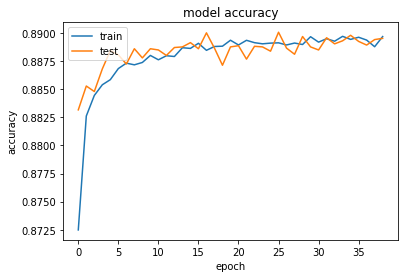

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

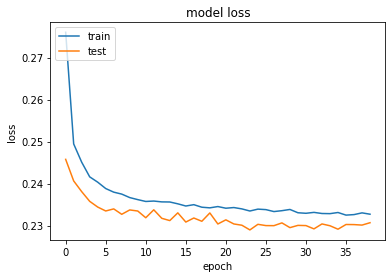

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#y_pred = model.predict(X_test_scale)
y_pred = model.predict(X_test_scale)

In [ ]:
y_pred_binary = np.where(y_pred >= .5, 1, 0) 

In [ ]:
#production model
print("Recall: ", recall_score(y_test, y_pred_binary))
print("Precision: ", precision_score(y_test, y_pred_binary))
print('F1: ', f1_score(y_test, y_pred_binary))
print("Accuracy: ", accuracy_score(y_test, y_pred_binary))

Recall:  0.5879381601102097
Precision:  0.7339957959105675
F1:  0.652898181200068
Accuracy:  0.8888798193344761


In [ ]:
#train longer:
batch_size = 128
epochs = 20

#t0 = datetime.now()
history = model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_scale,y_val)) 
#class_weight=class_weight 

Epoch 1/20
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2328 - accuracy: 0.8902 - precision: 0.7185 - recall: 0.6343 - val_loss: 0.2310 - val_accuracy: 0.8875 - val_precision: 0.7262 - val_recall: 0.5748
Epoch 2/20
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2327 - accuracy: 0.8896 - precision: 0.7166 - recall: 0.6324 - val_loss: 0.2304 - val_accuracy: 0.8881 - val_precision: 0.7244 - val_recall: 0.5835
Epoch 3/20
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2325 - accuracy: 0.8895 - precision: 0.7152 - recall: 0.6348 - val_loss: 0.2309 - val_accuracy: 0.8888 - val_precision: 0.7320 - val_recall: 0.5767
Epoch 4/20
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2326 - accuracy: 0.8894 - precision: 0.7154 - recall: 0.6330 - val_loss: 0.2302 - val_accuracy: 0.8884 - val_precision: 0.7213 - val_recall: 0.5922
Epoch 5/20
1149/1149 [==============================] - 3s 3ms/step - loss: 0.2326 - accuracy: 0

In [ ]:
# production model stats
y_pred = model.predict(X_scale)
y_pred_binary = np.where(y_pred >= .5, 1, 0) 

print("Recall: ", recall_score(y, y_pred_binary))
print("Precision: ", precision_score(y, y_pred_binary))
print('F1: ', f1_score(y, y_pred_binary))
print("Accuracy: ", accuracy_score(y, y_pred_binary))

Recall:  0.7876050795922017
Precision:  0.767444393612618
F1:  0.7773940483940374
Accuracy:  0.9027490564127778


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 21)                462       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                440       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 35)                735       
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 36        
Total params: 1,673
Trainable params: 1,673
Non-trainable params: 0
______________________________________________________

In [ ]:
model_num = 1

In [ ]:
#model_name = "turnout_score_issue_7_v" + str(model_num) + ".h5"
model_name = "turnout_score_issue_7_production" + str(model_num) + ".h5"
model_output_dir = os.path.join(gdrive_dir, "My Drive", "Homeless Coalition", 'trust fund campaign', "neural network models", "turnout")
model.save(os.path.join(model_output_dir, model_name))

In [ ]:
model_name

'turnout_score_issue_7_v1.h5'

# Reload Model

In [ ]:
model_name = "library turnout score prediction.h5"
model_output_dir = os.path.join(gdrive_dir, "My Drive", "Homeless Coalition", 'trust fund campaign', "neural network models", "turnout")

model = load_model(os.path.join(model_output_dir, model_name))

In [ ]:
y = model.predict(X_scale)

In [ ]:
voter_file.shape

(223404, 130)

In [ ]:
X_scale.shape

(223404, 21)

In [ ]:
voter_file['turnout_score'] = y

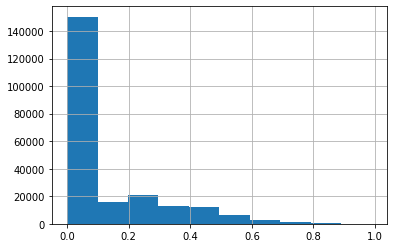

In [ ]:
voter_file['turnout_score'].hist()

In [ ]:
voter_file['turnout_score'].quantile(0.8)

0.25356447696685797

In [ ]:
voter_file[voter_file['turnout_score'] >= 0.25].shape[0]/voter_file.shape[0]

0.20372061377593956

In [ ]:
voter_file.head(2)

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,PARTY_AFFILIATION,RESIDENTIAL_ADDRESS1_voter,RESIDENTIAL_SECONDARY_ADDR,RESIDENTIAL_CITY_voter,RESIDENTIAL_STATE_voter,RESIDENTIAL_ZIP_voter,RESIDENTIAL_ZIP_PLUS4,RESIDENTIAL_COUNTRY,RESIDENTIAL_POSTALCODE,tigerlineid,side,tract,block,lat,lon,MAILING_ADDRESS1,MAILING_SECONDARY_ADDRESS,MAILING_CITY,MAILING_STATE,MAILING_ZIP,MAILING_ZIP_PLUS4,MAILING_COUNTRY,MAILING_POSTAL_CODE,CAREER_CENTER,CITY,CITY_SCHOOL_DISTRICT,COUNTY_COURT_DISTRICT,CONGRESSIONAL_DISTRICT,COURT_OF_APPEALS,EDU_SERVICE_CENTER_DISTRICT,EXEMPTED_VILL_SCHOOL_DISTRICT,LIBRARY,LOCAL_SCHOOL_DISTRICT,MUNICIPAL_COURT_DISTRICT,PRECINCT_NAME,PRECINCT_CODE,STATE_BOARD_OF_EDUCATION,STATE_REPRESENTATIVE_DISTRICT,STATE_SENATE_DISTRICT,TOWNSHIP,VILLAGE,WARD,PRIMARY-03/07/2000,GENERAL-11/07/2000,SPECIAL-05/08/2001,GENERAL-11/06/2001,PRIMARY-05/07/2002,GENERAL-11/05/2002,SPECIAL-05/06/2003,GENERAL-11/04/2003,PRIMARY-03/02/2004,GENERAL-11/02/2004,SPECIAL-02/08/2005,PRIMARY-05/03/2005,PRIMARY-09/13/2005,GENERAL-11/08/2005,SPECIAL-02/07/2006,PRIMARY-05/02/2006,GENERAL-11/07/2006,PRIMARY-05/08/2007,PRIMARY-09/11/2007,GENERAL-11/06/2007,PRIMARY-11/06/2007,GENERAL-12/11/2007,PRIMARY-03/04/2008,PRIMARY-10/14/2008,GENERAL-11/04/2008,GENERAL-11/18/2008,PRIMARY-05/05/2009,PRIMARY-09/08/2009,PRIMARY-09/15/2009,PRIMARY-09/29/2009,GENERAL-11/03/2009,PRIMARY-05/04/2010,PRIMARY-07/13/2010,PRIMARY-09/07/2010,GENERAL-11/02/2010,PRIMARY-05/03/2011,PRIMARY-09/13/2011,GENERAL-11/08/2011,PRIMARY-03/06/2012,GENERAL-11/06/2012,PRIMARY-05/07/2013,PRIMARY-09/10/2013,PRIMARY-10/01/2013,GENERAL-11/05/2013,PRIMARY-05/06/2014,GENERAL-11/04/2014,PRIMARY-05/05/2015,PRIMARY-09/15/2015,GENERAL-11/03/2015,PRIMARY-03/15/2016,GENERAL-06/07/2016,PRIMARY-09/13/2016,GENERAL-11/08/2016,PRIMARY-05/02/2017,PRIMARY-09/12/2017,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,PRIMARY-09/10/2019,GENERAL-11/05/2019,PRIMARY-03/17/2020,GENERAL-11/03/2020,block_str,fips_bg,census_block_number,race_name,GENDER,pct_under_30k,pct_post_grad,pct_renters,is_apartment,FIRST_ELIGIBLE_ELECTION,AGE,YEARS_REGISTERED,PCT_TOTAL_BALLOTS_CAST,PCT_PRIMARY_BALLOTS_CAST,turnout_score
0,OH0023466264,31,1884306,POKORNY,MICHAEL,F,NaN,1987-07-19,2015-12-22,ACTIVE,NaN,526 LIBERTY HILL,NaN,CINCINNATI,OH,45202,NaN,NaN,NaN,103953039.0,L,1800.0,1017.0,39.112280,-84.505615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 10-A,31-AGY,4,32,9,NaN,NaN,CINTI WARD 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,X,1017,390610018001,390610018001017,white,male,0.124260,0.272593,0.568047,0,PRIMARY-03/15/2016,33.793292,5.330595,0.2,0.0,0.015368
1,OH0023768498,31,1907972,SCARBOROUGH,ANTHONY,M,NaN,1968-08-24,2016-06-27,CONFIRMATION,NaN,1022 YALE AVE,NaN,CINCINNATI,OH,45206,NaN,NaN,NaN,103970492.0,L,3700.0,1005.0,39.128967,-84.487260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CINCINNATI CITY,CINCINNATI PUBLIC SCHOOLS CITY SD,NaN,1,1,NaN,NaN,NaN,NaN,HAMILTON-CO,CINCINNATI 9-D,31-AGQ,4,31,9,NaN,NaN,CINTI WARD 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1005,390610037001,390610037001005,white,male,0.413636,0.061789,0.636364,0,PRIMARY-09/13/2016,52.692676,4.815880,0.0,0.0,0.000174


In [ ]:
output_cols = ['SOS_VOTERID', 'LAST_NAME', 'FIRST_NAME', 'MIDDLE_NAME', 'SUFFIX', 'DATE_OF_BIRTH', 'REGISTRATION_DATE', 'VOTER_STATUS', 'PARTY_AFFILIATION', 'RESIDENTIAL_ADDRESS1_voter', 'RESIDENTIAL_SECONDARY_ADDR', 'RESIDENTIAL_CITY_voter', 'RESIDENTIAL_STATE_voter', 'RESIDENTIAL_ZIP_voter', 'RESIDENTIAL_ZIP_PLUS4', 'tigerlineid', 'side', 'tract', 'block', 'lat', 'lon', 'PRECINCT_NAME', 'WARD', 'fips_bg', 'census_block_number', 'race_name', 'GENDER', 'pct_under_30k', 'pct_post_grad', 'pct_renters', 'is_apartment', 'PCT_TOTAL_BALLOTS_CAST', 'PCT_PRIMARY_BALLOTS_CAST', 'turnout_score']

In [ ]:
output_filepath = os.path.join(gdrive_dir, "My Drive", "Homeless Coalition", 'trust fund campaign', 'predicted scores')

output_filename = "library turnout scores.csv"

voter_file[output_cols].to_csv(os.path.join(output_filepath, output_filename), index=False)